# Imports

In [1]:
import imutils
from imutils.video import VideoStream, FileVideoStream
from imutils import face_utils
import cv2
import time
import numpy as np
import dlib
from collections import OrderedDict
from pose_estimator import PoseEstimator
from stabilizer import Stabilizer
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import pandas as pd

%config Completer.use_jedi = False

# Helper functions

In [2]:
def show_image(path = None, img = None):
    if path:
        img = cv2.imread(path,1)
    while True:
        cv2.imshow('image',img)
        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            # do a bit of cleanup
            cv2.destroyAllWindows()
            break

# Face streamer

In [3]:
# Face streamer class 
class face_streamer:
    def __init__(self, predictor_path, filename = None):
        self.filename = filename
        
        # Initialize dlib's face detector (HOG-based)
        self.detector = dlib.get_frontal_face_detector()
        
        # Create landmark predictor.
        self.predictor = dlib.shape_predictor(predictor_path)
        
        self.facial_landmarks_idxs = OrderedDict([
            ("face", (0, 26)),
            ("left_eye", (37, 42)),
            ("right_eye", (43, 48)),
        ])
        
        # Colors to choose from
        self.colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
                (168, 100, 168), (158, 163, 32),
                (163, 38, 32), (180, 42, 220), (100, 150, 250)]
        
        # Define the width
        self.width = 400
        
        # RGB signals
        self.red_window = []
        self.green_window = []
        self.blue_window = []
        self.red = []
        self.green = []
        self.blue = []
        
        # RPY signals
        self.roll_window = []
        self.pitch_window = []
        self.yaw_window = []
        self.roll = []
        self.pitch = []
        self.yaw = []
        
        # POS Signals
        self.S1 = []
        self.S2 = []
        self.P = []
        
        # rPPG
        self.rppg = []
        
        # fft signals
        self.roll_fft = []
        self.pitch_fft = []
        self.yaw_fft = []
        
        self.rppg_fft = []
        
        # RMNS
        self.combined_rpy_fft = []
        self.rppg_fft_rmns = []
        
        # Freq filtered signals
        self.rppg_freq_filtered = []
        
        self.frame_count = 0
        
    def stream(self, display_face_bb = False, display_landmarks = False, display_overlay = False, 
               display_aam = False, display_pose_unstable = False, display_pose_stable = False, 
               display_pose_axis = False):
        # Update display parameters
        self.display_face_bb = display_face_bb
        self.display_landmarks = display_landmarks
        self.display_overlay = display_overlay
        self.display_aam = display_aam
        self.display_pose_unstable = display_pose_unstable
        self.display_pose_stable = display_pose_stable
        self.display_pose_axis = display_pose_axis
        
        # Start the stream
        self.start_stream()
        
        # Loop and stream
        while True:
            # Process each frame 
            self.process_frame()
                    
            # Show the frame
            cv2.imshow("Frame", self.frame)
            key = cv2.waitKey(1) & 0xFF
            
            # If the `q` key was pressed, break from the loop.
            if key == ord("q"):
                # Do some cleanup 
                self.end_stream()
                break
        
    def start_stream(self):
        self.set_params()
        if self.filename:
            self.vs = FileVideoStream(self.filename).start()
        else:
            self.vs = VideoStream(src=0).start()
        print("[INFO] camera sensor warming up...")
        time.sleep(1.0)
            
    def end_stream(self):
        # Do some cleanup
        cv2.destroyAllWindows()
        self.vs.stop()
        del self.vs
        self.num_frames = len(self.red)
        self.frame_vector = range(self.num_frames)
        
    def set_params(self):
        # Start default camera
        video = cv2.VideoCapture(0)

        # Find OpenCV version
        (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

        if int(major_ver)  < 3 :
            fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
            print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
        else :
            fps = video.get(cv2.CAP_PROP_FPS)
            print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

        # Number of frames to capture
        num_frames = 30;

        print("Capturing {0} frames".format(num_frames))

        # Start time
        start = time.time()

        # Grab a few frames
        for i in range(0, num_frames):
            ret, frame = video.read()

        # End time
        end = time.time()

        # Time elapsed
        seconds = end - start
        print ("Time taken : {0} seconds".format(seconds))

        # Calculate frames per second
        # Round to 30 or 60
        fps  = num_frames / seconds
        possible_rates = [30, 60] # these are the possible rates that we can round to
        self.fps = possible_rates[min(range(len(possible_rates)), key = lambda i: abs(possible_rates[i]-fps))] 
        print("Estimated frames per second : {0}".format(self.fps))

        # Find image dimensions and make the stablizer
        frame = imutils.resize(video.read()[1], width=self.width)
        self.height, _, _ = frame.shape
        self.pose_estimator = PoseEstimator(img_size=(self.height, self.width))
        self.pose_stabilizers = [Stabilizer(state_num=2, measure_num=1, cov_process=0.1, cov_measure=0.1) 
                            for _ in range(6)]
        
        # Set the frame limit 
        if self.fps == 30:
            self.frame_limit = 64
        else: # when fps = 60
            self.frame_limit = 512
        
        # Release video
        video.release()
    
    # Processes the signals when the frame limit has been reached
    def process_signals(self):
        self.apply_pos()
        self.apply_rmns()
        self.apply_freq_filtering()
        self.append_window_signals()
        
    # Processes the frame by updating numerical values and drawing on it (if specified)
    def process_frame(self):
        # Process and append the signals if the frame_limit is reached 
        if self.frame_count == self.frame_limit:
            self.process_signals()
        self.find_face()
        self.loop_faces()
        self.frame_count += 1
    
    # Finds faces in the image 
    def find_face(self):
        # Read and resize the frame
        self.frame = self.vs.read()
        self.frame = imutils.resize(self.vs.read(), width=self.width)
        # Get grayscale image and extract the bounding boxes with the detector 
        self.gray = cv2.cvtColor(self.frame, cv2.COLOR_BGR2GRAY)
        self.rects = self.detector(self.gray, 0)
    
    # Loops over the faces to update values and to draw on the frame
    def loop_faces(self):
        for rect in self.rects:
            # Get the bounding box 
            (self.bX, self.bY, self.bW, self.bH) = face_utils.rect_to_bb(rect)
            # Determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array.
            self.shape = face_utils.shape_to_np(self.predictor(self.gray, rect))
            # Set the facial points for the roi
            self.set_face_points()
            # Apply the aam
            self.apply_aam()
            # Get RGB values
            self.update_rgb() 
            # Try pose estimation
            self.pose = self.pose_estimator.solve_pose_by_68_points(
                self.shape.astype('float'))
            # Stabilize the pose
            self.stablize_pose()
            # Update RPY values 
            self.update_rpy()
            # If a face is found, draw on the face
            if self.shape.any():
                self.draw_frame()
                
    def update_rgb(self):
        self.red_window.append(np.sum(self.aam[:,:,0])/ self.num_aam_pixels)
        self.green_window.append(np.sum(self.aam[:,:,1])/ self.num_aam_pixels)
        self.blue_window.append(np.sum(self.aam[:,:,2])/ self.num_aam_pixels)

    def update_rpy(self):
        self.roll_window.append(self.steady_pose[0][2] * -1)
        self.pitch_window.append(self.steady_pose[0][1])
        self.yaw_window.append(self.steady_pose[0][0])
    
    # Applies the AAM by turning all cells outside of the face to 0
    def apply_aam(self):
        self.aam = np.zeros_like(self.frame)
        
        # Initialize masks 
        feature_mask = np.zeros((self.frame.shape[0], self.frame.shape[1]))  
        l_eye_mask = np.zeros((self.frame.shape[0], self.frame.shape[1]))  
        r_eye_mask = np.zeros((self.frame.shape[0], self.frame.shape[1]))  
        custom_mask = np.zeros((self.frame.shape[0], self.frame.shape[1]))
        
        # Define hulls for the facial components 
        hull = cv2.convexHull(self.face_points)
        hull_left_eye = cv2.convexHull(self.left_eye_points)
        hull_right_eye = cv2.convexHull(self.right_eye_points)
        custom_hull = cv2.convexHull(self.custom_points)
        
        # Fill the convex hulls for 1s, which mean that that pixel location is in the ROI.
        feature_mask = cv2.fillConvexPoly(feature_mask, hull, 1).astype(np.bool)
        l_eye_mask = cv2.fillConvexPoly(l_eye_mask, hull_left_eye, 1).astype(np.bool)
        r_eye_mask = cv2.fillConvexPoly(r_eye_mask, hull_right_eye, 1).astype(np.bool)
        custom_mask = cv2.fillConvexPoly(custom_mask, custom_hull, 1).astype(np.bool)
        
        # Use XOR to make a boolean mask of pixels inside our ROI
        final_mask = np.logical_xor(feature_mask, l_eye_mask)
        final_mask = np.logical_xor(final_mask, r_eye_mask)
        
        custom_final_mask = np.logical_xor(custom_mask, l_eye_mask)
        self.custom_final_mask = np.logical_xor(custom_final_mask, r_eye_mask)
        
        # Final AAM
        self.aam[self.custom_final_mask] = self.frame[self.custom_final_mask]
        self.num_aam_pixels = np.sum(self.custom_final_mask)
    
    # Apply POS to combine rgb signal in to rPPG signal
    def apply_pos(self):
        self.red_window = self.normalize_signal(self.red_window)
        self.green_window = self.normalize_signal(self.green_window)
        self.blue_window = self.normalize_signal(self.blue_window)
        C = np.array([self.red_window, self.green_window, self.blue_window])
        mean_color = np.mean(C, axis=1)
        diag_mean_color = np.diag(mean_color)
        diag_mean_color_inv = np.linalg.inv(diag_mean_color)
        Cn = np.matmul(diag_mean_color_inv,C)
        projection_matrix = np.array([[0,1,-1],[-2,1,1]])
        self.S_window = np.matmul(projection_matrix,Cn)
        std = np.array([1,np.std(self.S_window[0,:])/np.std(self.S_window[1,:])])
        self.P_window = np.matmul(std,self.S_window)
        self.rppg_window = self.P_window-np.mean(self.P_window)
        
    # empircally play with the normalizing in the freq domain
    # normalize RPY and RGB 
    # RPY -45 and +45 -> []
    # RPY to freq -> normalize -> combine (average)
    # todo - fix scale of rpy_fft signal
    # Applies Rhythmic Motion Noise Suppresion
    def apply_rmns(self):
        # Method 1: 1) temporal normalize RPY 2) FFT of normalized signals 3) combine
        # Normalize RPY signals
        self.roll_window = self.normalize_signal(self.roll_window)
        self.pitch_window = self.normalize_signal(self.pitch_window)
        self.yaw_window = self.normalize_signal(self.yaw_window)
        # Find fft of RPY and rPPG signals
        self.rppg_fft_window = np.abs(fft(self.rppg_window))
        self.roll_fft_window = np.abs(fft(self.roll_window))
        self.pitch_fft_window = np.abs(fft(self.pitch_window))
        self.yaw_fft_window = np.abs(fft(self.yaw_window))
        # Combine rpy_fft signals via averaging (divide by 3)
        self.combined_rpy_fft_window = (self.roll_fft_window + self.pitch_fft_window + self.yaw_fft_window)/3
        # Normalization
        self.combined_rpy_fft_window = (self.combined_rpy_fft_window - np.min(self.combined_rpy_fft_window))/(np.max(self.combined_rpy_fft_window)- np.min(self.combined_rpy_fft_window))
        
#         # Method 2: 1) FFT 2) normalize FFT 3) combine
#         # take FFT
#         self.rppg_fft_window = np.abs(fft(self.rppg_window))
#         self.roll_fft_window = np.abs(fft(self.roll_window))
#         self.pitch_fft_window = np.abs(fft(self.pitch_window))
#         self.yaw_fft_window = np.abs(fft(self.yaw_window))
#         # Normalize
#         self.roll_fft_window = self.normalize_signal(self.roll_fft_window)
#         self.pitch_fft_window = self.normalize_signal(self.pitch_fft_window)
#         self.yaw_fft_window = self.normalize_signal(self.yaw_fft_window)
#         # Combine rpy_fft signals via averaging (divide by 3)
#         self.combined_rpy_fft_window = (self.roll_fft_window + self.pitch_fft_window + self.yaw_fft_window)/3
        
#         # Method 3: 1) FFT 2) combine 3)normalize
#         # take FFT
#         self.rppg_fft_window = np.abs(fft(self.rppg_window))
#         self.roll_fft_window = np.abs(fft(self.roll_window))
#         self.pitch_fft_window = np.abs(fft(self.pitch_window))
#         self.yaw_fft_window = np.abs(fft(self.yaw_window))
#         # Combine rpy_fft signals via averaging (divide by 3)
#         self.combined_rpy_fft_window = self.normalize_signal((self.roll_fft_window + self.pitch_fft_window + self.yaw_fft_window)/3)
        
        # Apply RMNS
        self.rppg_fft_rmns_window = self.rppg_fft_window - self.combined_rpy_fft_window
        
    def stablize_pose(self):
        self.steady_pose = []
        pose_np = np.array(self.pose).flatten()
        for value, ps_stb in zip(pose_np, self.pose_stabilizers):
            ps_stb.update([value])
            self.steady_pose.append(ps_stb.state[0])
        self.steady_pose = np.reshape(self.steady_pose, (-1, 3))
    
    def set_face_points(self):
        # x,y locations of the facial landmarks
        self.face_points = self.shape[self.facial_landmarks_idxs['face'][0]:self.facial_landmarks_idxs['face'][1]]
        self.left_eye_points = self.shape[self.facial_landmarks_idxs['left_eye'][0]:self.facial_landmarks_idxs['left_eye'][1]]
        self.right_eye_points = self.shape[self.facial_landmarks_idxs['right_eye'][0]:self.facial_landmarks_idxs['right_eye'][1]]

        # Define custom ROI
        custom_roi = [0,1,2,3,13,14,15,16,17,18,19,20,21,22,23,24,25,26,33]
        avg_1 = np.asarray([np.mean([self.shape[3][0], self.shape[48][0]],dtype=np.int64), np.mean([self.shape[3][1],self.shape[48][1]],dtype=np.int64)])
        avg_2 = np.asarray([np.mean([self.shape[13][0], self.shape[54][0]],dtype=np.int64), np.mean([self.shape[13][1],self.shape[54][1]])],dtype=np.int64)
        points = [self.shape[i] for i in custom_roi]
        points.extend([avg_1, avg_2])
        self.custom_points = np.asarray(points)
    
    # TODO - Fix freq filtering
    def apply_freq_filtering(self):
        print(self.find_highest_freq(self.rppg_fft_rmns_window))
        # use bandpass filter
        self.rppg_freq_filtered_window = np.abs(ifft(self.rppg_fft_rmns_window))
    
    # Finds highest frequency in hz
    def find_highest_freq(self, signal):
        print(signal.shape)
        freq_hz = abs(fftfreq(signal.shape[0]) * fs.fps)
        max_idx = np.argmax(signal)
        max_freq = freq_hz[max_idx]
        return max_freq
        
    # normalize RGB signal by dividing by mean
    def normalize_signal(self, signal):
        signal = signal/np.mean(signal)
        return signal
    
    def resample_signal(self, signal):
        return signal
        
    def append_window_signals(self):
        print('append called')
        # RGB signals
        self.red.extend(self.red_window)
        self.green.extend(self.green_window)
        self.blue.extend(self.blue_window)
        
        # RPY signals
        self.roll.extend(self.roll_window)
        self.pitch.extend(self.pitch_window)
        self.yaw.extend(self.yaw_window)
        
        # POS Signals
        self.S1.extend(self.S_window[0,:])
        self.S2.extend(self.S_window[1,:])
        self.P.extend(self.P_window)
        
        # rPPG
        self.rppg.extend(self.rppg_window)
        
        # fft signals
        self.roll_fft.extend(self.roll_fft_window)
        self.pitch_fft.extend(self.pitch_fft_window)
        self.yaw_fft.extend(self.yaw_fft_window)
        
        self.rppg_fft.extend(self.rppg_fft_window)
        
        # RMNS
        self.combined_rpy_fft.extend(self.combined_rpy_fft_window)
        self.rppg_fft_rmns.extend(self.rppg_fft_rmns_window)
        
        # Freq filtered signals
        self.rppg_freq_filtered.extend(self.rppg_freq_filtered_window)
        
        self.reset_window_signals()
        
    def reset_window_signals(self):
        # Frame count
        self.frame_count = 0
        # RGB signals
        self.red_window = []
        self.green_window = []
        self.blue_window = []
        
        # RPY signals
        self.roll_window = []
        self.pitch_window = []
        self.yaw_window = []
        
    def draw_frame(self):
        if self.display_aam:
            self.draw_overlay()
        # Display bounding box if true
        if self.display_face_bb:
            self.draw_face_bb()
        # Display facial landmarks if true
        if self.display_landmarks:
            self.draw_landmarks()
        # Display the landmark overlay if true
        if self.display_overlay:
            self.draw_overlay()
        # Display the pose if true
        if self.display_pose_unstable or self.display_pose_stable:
            self.draw_pose()
        # Display the pose axis if true
        if self.display_pose_axis:
            self.draw_pose_axis()
                        
    def draw_face_bb(self):
        # Draw the bounding box on the frame
        cv2.rectangle(self.frame, (self.bX, self.bY), 
                      (self.bW+self.bX, self.bH+self.bY), (0, 255, 0), 1)
    
    def draw_landmarks(self):
        for (name, (i, j)) in self.facial_landmarks_idxs.items():
            # Loop over the subset of facial landmarks, drawing the specific face part
            for (x, y) in self.shape[i:j]:
                cv2.circle(self.frame, (x, y), 1, (0, 0, 255), -1)
    
    # Displays the overlay of the landmarks 
    def draw_overlay(self, alpha=0.75):
        # Apply the transparent overlay
#         cv2.addWeighted(self.aam, alpha, self.frame, 1 - alpha, 0,self.frame)
        # apply a color
        self.frame[self.custom_final_mask] = self.colors[0]

    
    def draw_pose(self):
        # Display the initial pose annotation if true
        if self.display_pose_unstable:
            self.pose_estimator.draw_annotation_box(
                self.frame, self.pose[0], self.pose[1], 
                color=(255, 128, 128))
        # Display the stablized pose annotation if true
        if self.display_pose_stable:
            self.pose_estimator.draw_annotation_box(
                self.frame, self.steady_pose[0], self.steady_pose[1], 
                color=(128, 255, 128))
        
    def draw_pose_axis(self):
        self.pose_estimator.draw_axis(self.frame, 
                                      self.steady_pose[0], self.steady_pose[1])
        
    def plot_rgb(self):
        plt.title('Normalized RGB values as a function of frames')
        plt.plot(self.frame_vector, self.red, color='red', label = 'Red')
        plt.plot(self.frame_vector, self.green, color='green', label='Green')
        plt.plot(self.frame_vector, self.blue, color='blue', label='Blue')
        plt.xlabel('Frame')
        plt.ylabel('Value')
        plt.legend(loc = 'upper right')
        
    def plot_projected_signal(self):
        plt.title('Projected Signals')
        plt.plot(self.frame_vector, self.S1)
        plt.plot(self.frame_vector, self.S2)
        plt.xlabel('Frame')
        plt.ylabel('Value')
        
    def plot_rppg(self):
        plt.title('rPPG signal')
        plt.plot(self.frame_vector, self.rppg)
        plt.xlabel('Frame')
        plt.ylabel('Value')
    
    def plot_rpy(self):
        plt.title('RPY values as a function of frames')
        plt.plot(self.frame_vector, self.roll, color='cyan', label = 'Roll')
        plt.plot(self.frame_vector, self.pitch, color='magenta', label='Pitch')
        plt.plot(self.frame_vector, self.yaw, color='yellow', label='Yaw')
        plt.xlabel('Frame')
        plt.ylabel('Value')
        plt.legend(loc = 'upper right')
        
    def plot_fft(self):
        plt.subplot(1,2,1)
        plt.title('FFT of RPY signals')
        plt.plot(self.frame_vector, self.roll_fft, color='cyan', label = 'Roll')
        plt.plot(self.frame_vector, self.pitch_fft, color='magenta', label='Pitch')
        plt.plot(self.frame_vector, self.yaw_fft, color='yellow', label='Yaw')
        plt.legend(loc = 'upper right')
        plt.subplot(1,2,2)
        plt.title('FFT rPPG signals')
        plt.plot(self.frame_vector, self.rppg_fft, label = 'rPPG')
        
    def plot_combined_rpy_fft(self):
        plt.subplot(1,2,1)
        plt.title('Combined FFT of RPY signal')
        plt.plot(self.frame_vector, self.combined_rpy_fft)
        plt.subplot(1,2,2)
        plt.title('Combined FFT of rPPG signal')
        plt.plot(self.frame_vector, self.rppg_fft)
        
    def plot_rppg_rmns(self):
        plt.title('FFT of rPPG signal after Rhythmic Noise Suppression')
        plt.plot(self.frame_vector, self.rppg_fft_rmns)

    def plot_rppg_freq_filtered(self):
        plt.title('rPPG after Frequency Filter')
        plt.plot(self.frame_vector, self.rppg_freq_filtered)
       

In [4]:
predictor_path = "../models/shape_predictor_68_face_landmarks.dat"
fs = face_streamer(predictor_path)
# If display_aam is true, this is all you will see
fs.stream(display_face_bb = False, display_landmarks = True, display_overlay = False, display_aam = True,
          display_pose_unstable = False, display_pose_stable = True, display_pose_axis = True)

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.0
Capturing 30 frames
Time taken : 1.5165653228759766 seconds
Estimated frames per second : 30
successful init
[INFO] camera sensor warming up...
(64,)
14.53125
append called
(64,)
4.21875
append called
(64,)
6.09375
append called
(64,)
3.75
append called


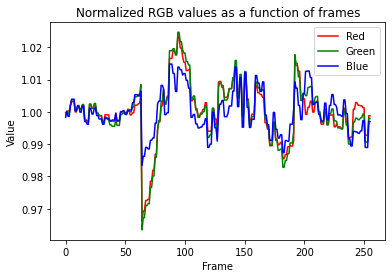

In [5]:
# Graph RGB
fs.plot_rgb()

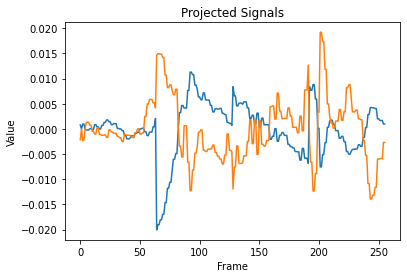

In [6]:
# Plot the projected signal
fs.plot_projected_signal()

Text(0, 0.5, 'Value')

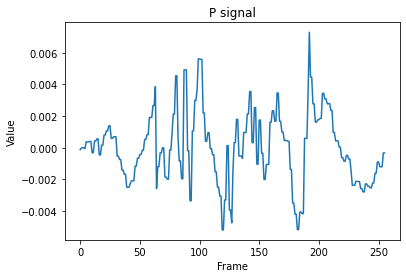

In [7]:
# P 
plt.title('P signal')
plt.plot(fs.frame_vector, fs.P)
plt.xlabel('Frame')
plt.ylabel('Value')

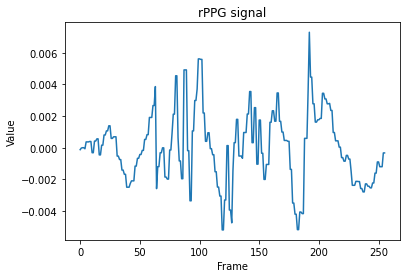

In [8]:
# Graph rPPG signals
fs.plot_rppg()

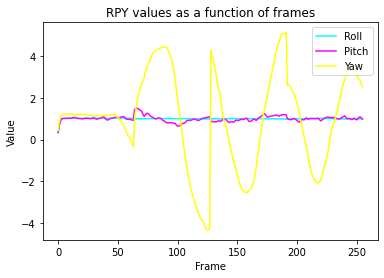

In [9]:
# Graph RPY
fs.plot_rpy()

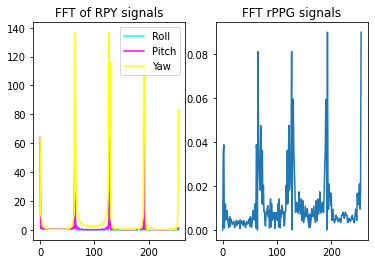

In [10]:
# Graph FFT of RGB and RPY signals signals
fs.plot_fft()

In [11]:
max1 = np.max(fs.rppg_fft)
max1_idx = np.argmax(fs.rppg_fft)
fs.rppg_fft[max1_idx] = 0

max2 = np.max(fs.rppg_fft)
max2_idx = np.argmax(fs.rppg_fft)

print(max1_idx, max1)
print(max2_idx, max2)

193 0.08993726635021883
255 0.08993726635021883


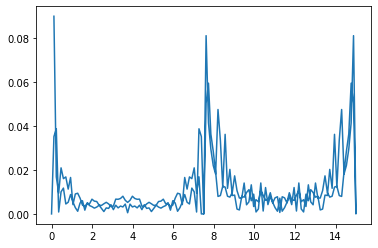

In [12]:
freq = fftfreq(fs.num_frames)
freq_hz = abs(freq * fs.fps)
plt.plot(freq_hz, fs.rppg_fft)

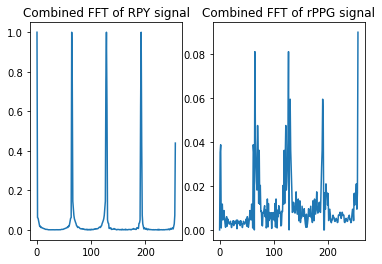

In [13]:
# Graph the combined RPY FFT
fs.plot_combined_rpy_fft()

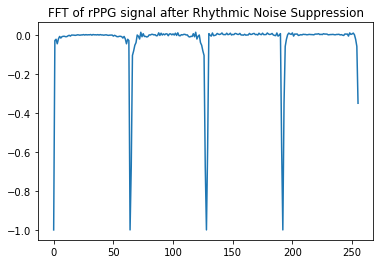

In [14]:
# Graph the rPPG FFT after Rhythmic Noise Suppression
fs.plot_rppg_rmns()

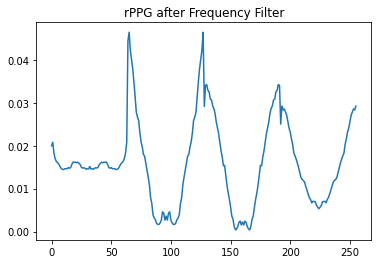

In [15]:
# Graph the rPPG after frequency filtering
fs.plot_rppg_freq_filtered()

## Hand-cleaned PPG signal

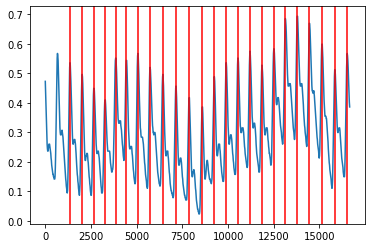

In [16]:
df = pd.read_csv('/media/brandon/Seagate HDD/datasets/vicarPPG/GroundTruth/PPG/Cleaned/01-base PPG.csv')
stop = 1000
plt.plot(df['Time'][:stop],df['Signal'][:stop])
peaks = [df['Time'][idx] for idx, element in enumerate(df['Peaks']) if element == 1]

for peak in peaks:
    if peak >= df['Time'][stop]:
        break
    plt.axvline(x = peak, color = 'r')